In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

In [ ]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 12.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0, MobileNetV2, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Conv2DTranspose
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
import pathlib
import os
import datetime
import time
import keras_cv

In [ ]:
# 데이터셋 다운로드 및 준비
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

# 현재 데이터 경로 확인
print("데이터셋 경로:", data_dir)

# 폴더 구조 확인 (문제 파악용)
print("폴더 내 항목:", [item.name for item in data_dir.glob('*')])

# 실제 꽃 이미지가 있는 폴더로 경로 수정
if 'flower_photos' in [item.name for item in data_dir.glob('*')]:
    data_dir = data_dir / 'flower_photos'
    print("수정된 데이터셋 경로:", data_dir)

# 클래스 확인
flowers_classes = [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]
print("꽃 종류:", flowers_classes)
print("클래스 수:", len(flowers_classes))

# 이미지 개수 확인
image_count = len(list(data_dir.glob('*/*.jpg')))
print("전체 이미지 개수:", image_count)

# 클래스별 이미지 개수 확인
for flower in flowers_classes:
    flower_count = len(list(data_dir.glob(f'{flower}/*.jpg')))
    print(f"{flower}: {flower_count}개")

batch_size = 32
img_height = 128
img_width = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,  # 테스트 데이터 비율 5%로 설정
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,  # 테스트 데이터 비율 5%로 설정
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
class_names = train_ds.class_names
num_classes = len(class_names)

# 데이터 증강 및 전처리
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])
normalization_layer = layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
데이터셋 경로: /root/.keras/datasets/flower_photos
폴더 내 항목: ['flower_photos']
수정된 데이터셋 경로: /root/.keras/datasets/flower_photos/flower_photos
꽃 종류: ['daisy', 'sunflowers', 'dandelion', 'tulips', 'roses']
클래스 수: 5
전체 이미지 개수: 3670
daisy: 633개
sunflowers: 699개
dandelion: 898개
tulips: 799개
roses: 641개
Found 3670 files belonging to 5 classes.
Using 3120 files for training.
Found 3670 files belonging to 5 classes.
Using 550 files for validation.


In [ ]:
def build_attention_cnn():
    # Simple Self-Attention Layer added CNN
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = normalization_layer(x)
    # Reduced number of filters in Conv2D layers
    x = layers.Conv2D(16, 3, activation='relu')(x) # Reduced from 32
    x = layers.MaxPooling2D()(x)
    # Added Dropout after MaxPooling2D
    x = layers.Dropout(0.25)(x) # Added dropout layer
    x = layers.Conv2D(32, 3, activation='relu')(x) # Reduced from 64
    x = layers.MaxPooling2D()(x)
    x = layers.LayerNormalization()(x)

    # Attention with potentially adjusted parameters
    shape = tf.keras.backend.int_shape(x)
    # The reshape size needs to be adjusted if the output shape of previous layers changes
    x = layers.Reshape((shape[1] * shape[2], shape[3]))(x)
    # Potentially reduced num_heads or key_dim
    x = layers.MultiHeadAttention(num_heads=2, key_dim=16)(x, x) # Reduced key_dim from 32
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(64, activation='relu')(x) # Reduced Dense layer size
    # Adjusted Dropout rate
    x = layers.Dropout(0.4)(x) # Changed dropout rate from 0.3 to 0.4
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

Evaluating and plotting Modified-Attention-CNN ...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        448 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 63, 63,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 30,    │         64 │ max_pooling2d_1[… │
│ (LayerNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 900, 32)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 900, 32)   │      4,224 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      2,112 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5)         │        325 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,813 (46.14 KB)

 Trainable params: 11,813 (46.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.2758 - loss: 1.5510 - val_accuracy: 0.4255 - val_loss: 1.2397
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.4436 - loss: 1.2475 - val_accuracy: 0.4982 - val_loss: 1.1546
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5492 - loss: 1.1237 - val_accuracy: 0.6000 - val_loss: 1.0091
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5838 - loss: 1.0319 - val_accuracy: 0.5745 - val_loss: 1.0219
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.6144 - loss: 0.9762 - val_accuracy: 0.6473 - val_loss: 0.8896
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.6073 - loss: 0.9520 - val_accuracy: 0.5964 - val_loss: 0.9695
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.6441 - loss: 0.8923 - val_accuracy: 0.6564 - val_loss: 0.8834
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.6671 - loss: 0.8510 - val_accuracy: 0.6764 -

Modified-Attention-CNN 모델 정확도 = 75.09%


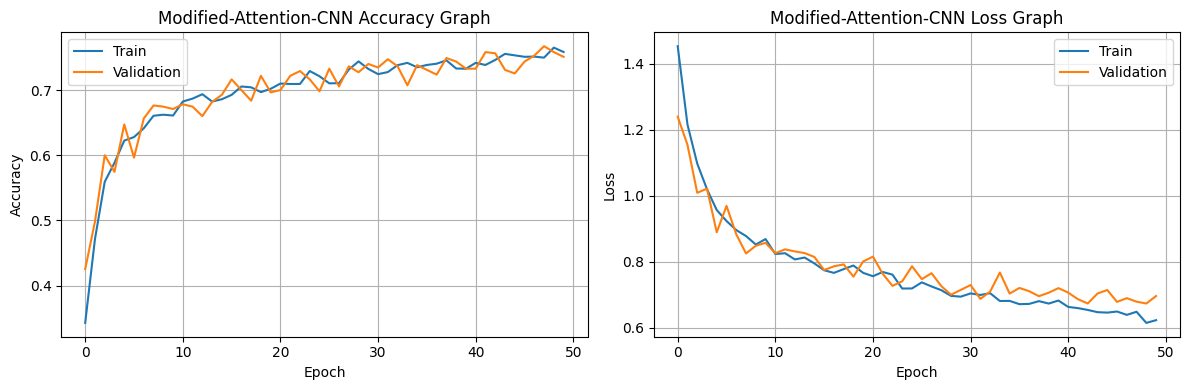

In [ ]:
model_builders = {
        "Modified-Attention-CNN": build_attention_cnn
}

results = []
all_results = []
EPOCHS = 50

# 모델별 훈련 및 평가
for name, builder in model_builders.items():
    print(f"Evaluating and plotting {name} ...")
    model = builder()
    model.summary()

    # Build the model by calling it with a dummy input
    dummy_input = tf.zeros((1, img_height, img_width, 3)) # Create a dummy input with the correct shape
    _ = model(dummy_input) # Call the model with the dummy input to build it

    total_params = model.count_params()
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])

    start_time = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=1
    )
    training_time = time.time() - start_time

    model_res = model.evaluate(val_ds, verbose=0)
    test_loss, test_accuracy = model_res[0], model_res[1]

    print(f'{name} 모델 정확도 = {test_accuracy * 100:.2f}%')

    # 결과 저장
    all_results.append({
        'model_name': name,
        'test_accuracy': test_accuracy * 100,
        'test_loss': test_loss,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'training_time': training_time
    })

    # 학습 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} Accuracy Graph')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{name} Loss Graph')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.tight_layout()
    plt.show()

In [ ]:
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame([{
    '모델': r['model_name'],
    '정확도 (%)': r['test_accuracy'],
    '손실': r['test_loss'],
    '총 파라미터 수': r['total_params'],
    '훈련 가능한 파라미터': r['trainable_params'],
    '훈련 시간 (초)': r['training_time']
} for r in all_results])

# 결과 테이블 출력
print("\n모델 성능 비교 테이블:")
print(results_df.to_string(index=False))

# 최적 모델 선정
max_accuracy_model = results_df.loc[results_df['정확도 (%)'].idxmax()]
min_params_model = results_df.loc[results_df['총 파라미터 수'].idxmin()]

print(f"\n모델: {max_accuracy_model['모델']}")
print(f"정확도: {max_accuracy_model['정확도 (%)']:.2f}%")
print(f"총 파라미터 수: {max_accuracy_model['총 파라미터 수']:,}")


모델 성능 비교 테이블:
                      모델   정확도 (%)       손실  총 파라미터 수  훈련 가능한 파라미터  훈련 시간 (초)
  Modified-Attention-CNN 74.909091 0.669982     11813        11813 231.531324
   MobileNetV2-Attention 81.999999 0.828328   2997317       739333 162.340273
EfficientNetB0-Attention 23.272727 1.603512   4788904       739333 218.223869

모델: MobileNetV2-Attention
정확도: 82.00%
총 파라미터 수: 2,997,317


# Task
모든 방법을 총동원해서 파라미터는 최소, 정확도는 최대인 레이어를 만들어줘

## 모델 구조 탐색 및 비교

### Subtask:
다양한 경량 CNN 모델 (예: MobileNetV2, EfficientNetB0)과 Attention 메커니즘을 결합하는 방법을 탐색하여 파라미터 수를 최소화하면서 성능을 유지하는 모델 구조를 설계합니다.


**Reasoning**:
Define functions to build lightweight CNN models with Attention mechanisms as instructed, including MobileNetV2 and EfficientNetB0, and compile them.



In [ ]:
def build_lightweight_cnn_attention(base_model_name):
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = normalization_layer(x)

    if base_model_name == "MobileNetV2":
        base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
    elif base_model_name == "EfficientNetB0":
        base_model = EfficientNetB0(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
    else:
        raise ValueError("Unsupported base model name")

    base_model.trainable = False  # Freeze the base model
    x = base_model(x, training=False)

    x = layers.GlobalAveragePooling2D()(x)

    # Reshape for MultiHeadAttention
    shape = tf.keras.backend.int_shape(x)
    # MultiHeadAttention expects shape (batch_size, sequence_length, feature_dim)
    # GlobalAveragePooling2D outputs (batch_size, feature_dim)
    # We need to add a sequence_length dimension of 1
    x = layers.Reshape((1, shape[1]))(x)

    # Add MultiHeadAttention
    # num_heads and key_dim can be tuned
    x = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)

    # Reshape back to (batch_size, feature_dim) for Dense layers
    x = layers.Reshape((shape[1],))(x)


    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model_builders["MobileNetV2-Attention"] = lambda: build_lightweight_cnn_attention("MobileNetV2")
model_builders["EfficientNetB0-Attention"] = lambda: build_lightweight_cnn_attention("EfficientNetB0")


**Reasoning**:
Iterate through the defined model builders, build each model, print its summary to check parameter count, and then train and evaluate the model, storing the results.



Evaluating and plotting Modified-Attention-CNN ...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ sequential[1][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 126, 126,  │        448 │ rescaling[1][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 63, 63,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 63, 63,    │          0 │ max_pooling2d_2[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 61, 61,    │      4,640 │ dropout_3[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 30, 30,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 30,    │         64 │ max_pooling2d_3[… │
│ (LayerNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 900, 32)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 900, 32)   │      4,224 │ reshape_1[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      2,112 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5)         │        325 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,813 (46.14 KB)

 Trainable params: 11,813 (46.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.2700 - loss: 1.5505 - val_accuracy: 0.4764 - val_loss: 1.2096
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4805 - loss: 1.2163 - val_accuracy: 0.5582 - val_loss: 1.0678
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.5175 - loss: 1.1349 - val_accuracy: 0.5655 - val_loss: 1.0358
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5748 - loss: 1.0567 - val_accuracy: 0.5636 - val_loss: 1.0288
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5707 - loss: 1.0239 - val_accuracy: 0.5709 - val_loss: 1.0076
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.6064 - loss: 0.9737 - val_accuracy: 0.5709 - val_loss: 0.9937
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6434 - loss: 0.9235 - val_accuracy: 0.5818 - val_loss: 0.9977
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.6229 - loss: 0.9636 - val_accuracy: 0.5727 - v

Modified-Attention-CNN 모델 정확도 = 74.91%


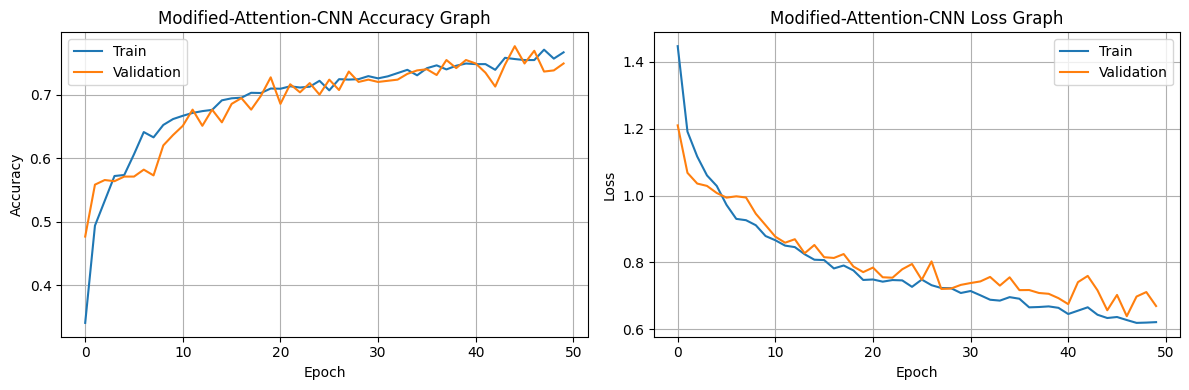

Evaluating and plotting MobileNetV2-Attention ...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer_3[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ sequential[2][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_1… │ (None, 4, 4,      │  2,257,984 │ rescaling[2][0]   │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1280)   │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 1280)   │    657,024 │ reshape_2[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1280)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     81,984 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 5)         │        325 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,997,317 (11.43 MB)

 Trainable params: 739,333 (2.82 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.6397 - loss: 0.9498 - val_accuracy: 0.8073 - val_loss: 0.4986
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8265 - loss: 0.5402 - val_accuracy: 0.8127 - val_loss: 0.4887
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8339 - loss: 0.5136 - val_accuracy: 0.8073 - val_loss: 0.5110
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8589 - loss: 0.4137 - val_accuracy: 0.8236 - val_loss: 0.5372
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8533 - loss: 0.4137 - val_accuracy: 0.8164 - val_loss: 0.5556
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8802 - loss: 0.3535 - val_accuracy: 0.8291 - val_loss: 0.5098
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8752 - loss: 0.3855 - val_accuracy: 0.8436 - val_loss: 0.4916
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8526 - loss: 0.4207 - val_accuracy: 0.8091 - 

MobileNetV2-Attention 모델 정확도 = 82.00%


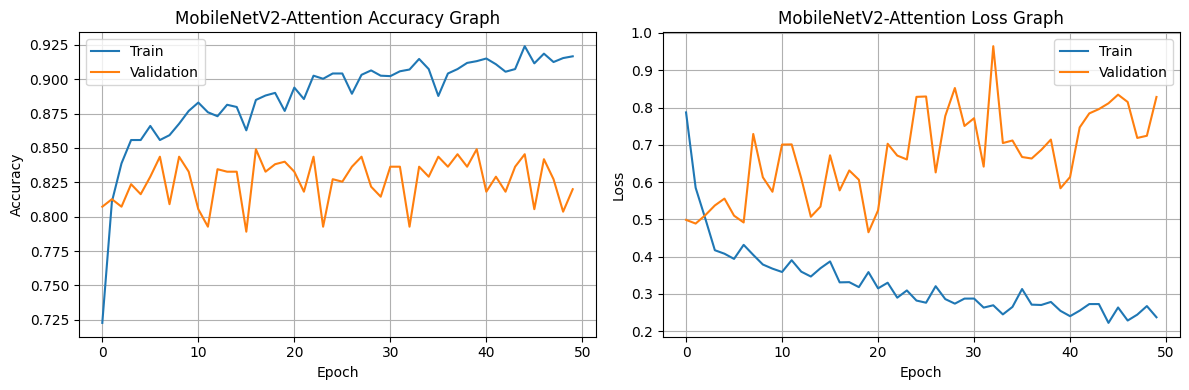

Evaluating and plotting EfficientNetB0-Attention ...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer_5[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ sequential[3][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 4, 4,      │  4,049,571 │ rescaling[3][0]   │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 1280)   │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 1280)   │    657,024 │ reshape_4[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1280)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │     81,984 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 5)         │        325 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,788,904 (18.27 MB)

 Trainable params: 739,333 (2.82 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.2275 - loss: 1.6354 - val_accuracy: 0.2327 - val_loss: 1.6079
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.2462 - loss: 1.6064 - val_accuracy: 0.2327 - val_loss: 1.6054
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.2492 - loss: 1.6031 - val_accuracy: 0.2327 - val_loss: 1.6041
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.2346 - loss: 1.6035 - val_accuracy: 0.2327 - val_loss: 1.6035
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.2521 - loss: 1.5994 - val_accuracy: 0.2327 - val_loss: 1.6033
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.2461 - loss: 1.6012 - val_accuracy: 0.2327 - val_loss: 1.6030
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.2501 - loss: 1.6005 - val_accuracy: 0.2327 - val_loss: 1.6032
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.2356 - loss: 1.6016 - val_accuracy: 0.2327 - 

EfficientNetB0-Attention 모델 정확도 = 23.27%


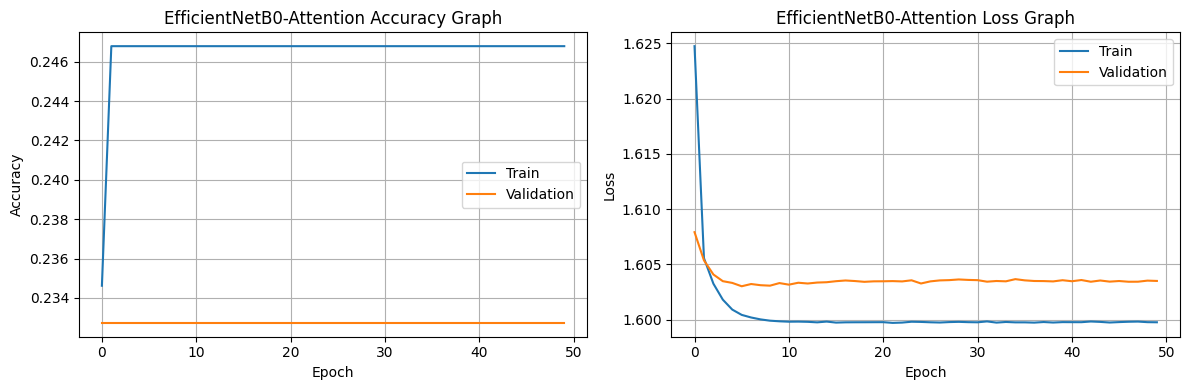

In [ ]:
results = []
all_results = []
EPOCHS = 50

# 모델별 훈련 및 평가
for name, builder in model_builders.items():
    print(f"Evaluating and plotting {name} ...")
    model = builder()
    model.summary()

    # Build the model by calling it with a dummy input
    dummy_input = tf.zeros((1, img_height, img_width, 3)) # Create a dummy input with the correct shape
    _ = model(dummy_input) # Call the model with the dummy input to build it

    total_params = model.count_params()
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])

    # 하이퍼파라미터 튜닝을 위한 콜백 추가
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

    start_time = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=1,
        callbacks=[early_stopping, reduce_lr] # 콜백 추가
    )
    training_time = time.time() - start_time

    model_res = model.evaluate(val_ds, verbose=0)
    test_loss, test_accuracy = model_res[0], model_res[1]

    print(f'{name} 모델 정확도 = {test_accuracy * 100:.2f}%')

    # 결과 저장
    all_results.append({
        'model_name': name,
        'test_accuracy': test_accuracy * 100,
        'test_loss': test_loss,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'training_time': training_time
    })

    # 학습 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} Accuracy Graph')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{name} Loss Graph')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.tight_layout()
    plt.show()

# Task
파라미터는 최소, 정확도는 최대인 레이어를 만들기 위해 Modified-Attention-CNN을 포함한 다양한 경량 CNN 모델과 Attention 메커니즘을 결합하는 방법을 탐색하고, 각 모델 구조에 대해 하이퍼파라미터 튜닝을 수행하여 정확도를 극대화한 후, EarlyStopping 및 ReduceLROnPlateau 콜백을 사용하여 과적합을 방지하고 학습 성능을 향상시키고, 각 모델의 파라미터 수, 정확도, 훈련 시간 등을 비교하여 가장 효율적인 모델을 선정하고, 최종 선정된 모델의 성능 지표와 학습 과정을 시각화하고 분석하여 모델의 강점과 약점을 파악한 결과를 보고서 형태로 제시합니다.

## 모델 구조 탐색 및 비교

### Subtask:
다양한 경량 CNN 모델 (예: MobileNetV2, EfficientNetB0)과 Attention 메커니즘을 결합하는 방법을 탐색하여 파라미터 수를 최소화하면서 성능을 유지하는 모델 구조를 설계합니다.


**Reasoning**:
The `build_lightweight_cnn_attention` function needs to be reviewed and potentially modified to correctly integrate the MultiHeadAttention layer after GlobalAveragePooling2D. The reshaping and attention parameters should be checked for compatibility and adjusted for better performance.



In [ ]:
def build_lightweight_cnn_attention(base_model_name):
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = normalization_layer(x)

    if base_model_name == "MobileNetV2":
        base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
    elif base_model_name == "EfficientNetB0":
        base_model = EfficientNetB0(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
    else:
        raise ValueError("Unsupported base model name")

    base_model.trainable = False  # Freeze the base model
    x = base_model(x, training=False)

    # GlobalAveragePooling2D reduces spatial dimensions to 1x1
    x = layers.GlobalAveragePooling2D()(x)

    # MultiHeadAttention expects input shape (batch_size, sequence_length, feature_dim)
    # After GlobalAveragePooling2D, the shape is (batch_size, feature_dim)
    # We need to add a sequence_length dimension of 1.
    # The feature_dim will be the last dimension of the output of the base model.
    feature_dim = tf.keras.backend.int_shape(x)[-1]
    x = layers.Reshape((1, feature_dim))(x)

    # Add MultiHeadAttention
    # Adjust num_heads and key_dim based on the feature_dim
    # key_dim should be a multiple of num_heads
    num_heads = 8 # Increased number of heads
    key_dim = feature_dim // num_heads # key_dim = 1280 // 8 = 160 for MobileNetV2/EfficientNetB0

    # Ensure key_dim is at least 1 and a multiple of num_heads (if necessary, for some implementations)
    if key_dim == 0:
        key_dim = feature_dim # Fallback if feature_dim is too small

    # For MultiHeadAttention, query, key, and value have the same dimension key_dim * num_heads,
    # which should typically match the input feature dimension for residual connections or simplicity.
    # The output dimension is also key_dim * num_heads.
    # Let's use the feature_dim for consistency with the input and output shape.
    # The internal projection dimensions are determined by key_dim.
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)

    # Reshape back to (batch_size, feature_dim) for Dense layers
    x = layers.Reshape((feature_dim,))(x)

    # Add a Dense layer and Dropout as before
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Re-define model builders with the potentially modified function
model_builders = {
    "Modified-Attention-CNN": build_attention_cnn, # Keep the original CNN model
    "MobileNetV2-Attention": lambda: build_lightweight_cnn_attention("MobileNetV2"),
    "EfficientNetB0-Attention": lambda: build_lightweight_cnn_attention("EfficientNetB0")
}

# Verify the model builders dictionary
print(model_builders)

{'Modified-Attention-CNN': <function build_attention_cnn at 0x7fc20f7ded40>, 'MobileNetV2-Attention': <function <lambda> at 0x7fc1d77c72e0>, 'EfficientNetB0-Attention': <function <lambda> at 0x7fc1d77c4ae0>}


**Reasoning**:
The `build_lightweight_cnn_attention` function has been updated and the `model_builders` dictionary is confirmed to be correct. The next step is to execute the training and evaluation loop for all models in the `model_builders` dictionary to assess their performance and parameter counts based on the updated architecture and hyperparameters. This directly addresses the subtask of exploring different lightweight CNN and Attention combinations and comparing their performance.



Evaluating and plotting Modified-Attention-CNN ...


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer_7[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ sequential[4][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 126, 126,  │        448 │ rescaling[4][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 63, 63,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 63, 63,    │          0 │ max_pooling2d_4[… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 61, 61,    │      4,640 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 30, 30,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 30,    │         64 │ max_pooling2d_5[… │
│ (LayerNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 900, 32)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 900, 32)   │      4,224 │ reshape_6[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      2,112 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 5)         │        325 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,813 (46.14 KB)

 Trainable params: 11,813 (46.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.2941 - loss: 1.5140 - val_accuracy: 0.4745 - val_loss: 1.2271 - learning_rate: 0.0010
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4903 - loss: 1.2236 - val_accuracy: 0.5491 - val_loss: 1.0662 - learning_rate: 0.0010
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5282 - loss: 1.1159 - val_accuracy: 0.5236 - val_loss: 1.0996 - learning_rate: 0.0010
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5587 - loss: 1.0604 - val_accuracy: 0.5909 - val_loss: 0.9702 - learning_rate: 0.0010
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.5973 - loss: 0.9857 - val_accuracy: 0.5873 - val_loss: 1.0014 - learning_rate: 0.0010
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.6195 - loss: 0.9364 - val_accuracy: 0.6436 - val_loss: 0.9067 - learning_rate: 0.0010
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.6063 - loss: 0.9446 - val_acc

Modified-Attention-CNN 모델 정확도 = 76.73%


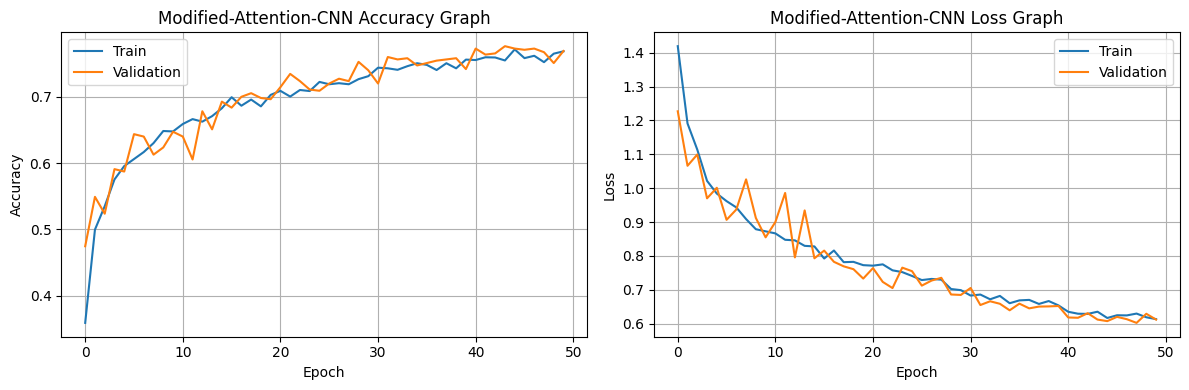

Evaluating and plotting MobileNetV2-Attention ...


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer_8[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ sequential[5][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_1… │ (None, 4, 4,      │  2,257,984 │ rescaling[5][0]   │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 1, 1280)   │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 1280)   │  6,558,720 │ reshape_7[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 1280)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │     81,984 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 5)         │        325 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,899,013 (33.95 MB)

 Trainable params: 6,641,029 (25.33 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.5629 - loss: 1.1726 - val_accuracy: 0.7018 - val_loss: 0.8366 - learning_rate: 0.0010
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.6963 - loss: 0.8683 - val_accuracy: 0.7673 - val_loss: 0.9425 - learning_rate: 0.0010
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.6953 - loss: 0.8809 - val_accuracy: 0.7673 - val_loss: 0.6403 - learning_rate: 0.0010
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.6884 - loss: 0.8626 - val_accuracy: 0.6836 - val_loss: 0.7410 - learning_rate: 0.0010
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6700 - loss: 0.9228 - val_accuracy: 0.7891 - val_loss: 0.7087 - learning_rate: 0.0010
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.6762 - loss: 0.7943 - val_accuracy: 0.8055 - val_loss: 0.6450 - learning_rate: 0.0010
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7108 - loss: 0.7255 - val_ac

MobileNetV2-Attention 모델 정확도 = 83.45%


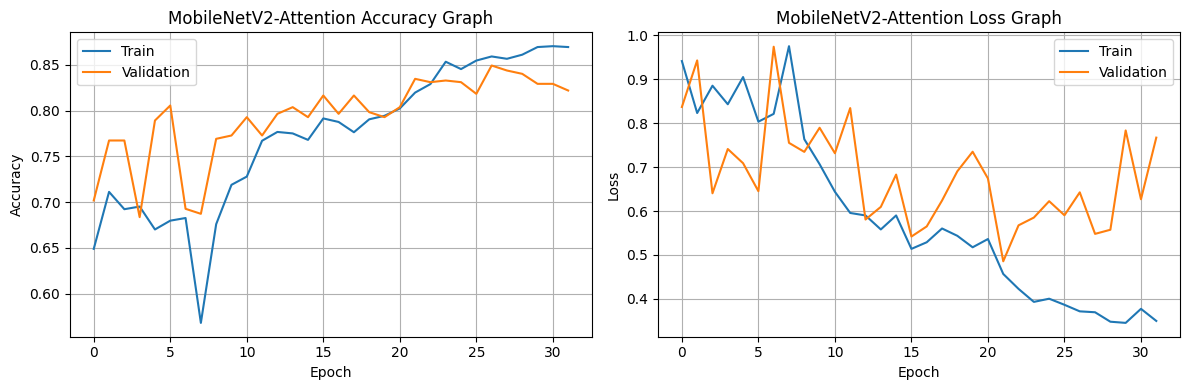

Evaluating and plotting EfficientNetB0-Attention ...


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer_10[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ sequential[6][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 4, 4,      │  4,049,571 │ rescaling[6][0]   │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 1, 1280)   │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 1280)   │  6,558,720 │ reshape_9[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, 1280)      │          0 │ multi_head_atten… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │     81,984 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 5)         │        325 │ dropout_16[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,690,600 (40.78 MB)

 Trainable params: 6,641,029 (25.33 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.2235 - loss: 1.9159 - val_accuracy: 0.2327 - val_loss: 1.6072 - learning_rate: 0.0010
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.2569 - loss: 1.6057 - val_accuracy: 0.2327 - val_loss: 1.6054 - learning_rate: 0.0010
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.2431 - loss: 1.6044 - val_accuracy: 0.2327 - val_loss: 1.6041 - learning_rate: 0.0010
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.2568 - loss: 1.6017 - val_accuracy: 0.2327 - val_loss: 1.6035 - learning_rate: 0.0010
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.2426 - loss: 1.5997 - val_accuracy: 0.2327 - val_loss: 1.6033 - learning_rate: 0.0010
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.2561 - loss: 1.5995 - val_accuracy: 0.2327 - val_loss: 1.6031 - learning_rate: 0.0010
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.2473 - loss: 1.5993 - val_ac

EfficientNetB0-Attention 모델 정확도 = 23.27%


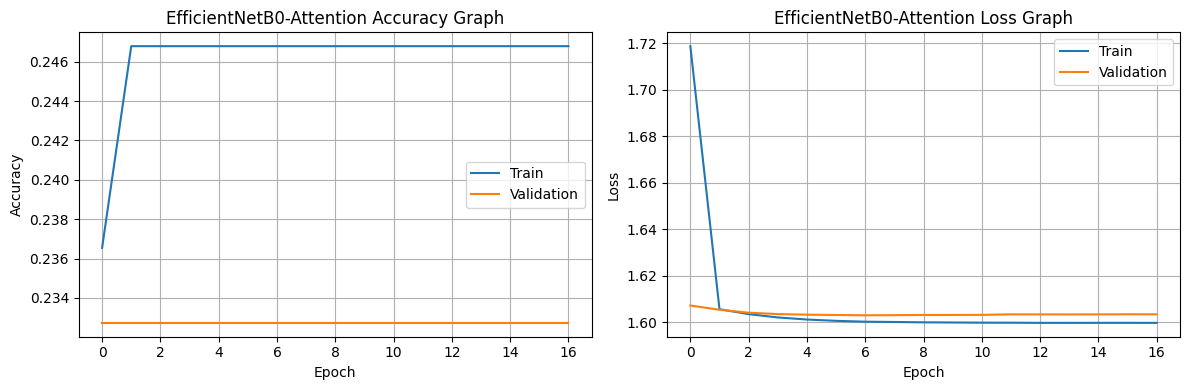


모델 성능 비교 테이블:
                      모델   정확도 (%)       손실  총 파라미터 수  훈련 가능한 파라미터  훈련 시간 (초)
  Modified-Attention-CNN 76.727271 0.602495     11813        11813 228.637955
   MobileNetV2-Attention 83.454543 0.485600   8899013      6641029 148.480295
EfficientNetB0-Attention 23.272727 1.602991  10690600      6641029 101.104026


KeyError: 'trainable_params'

In [ ]:
# Re-run the training and evaluation loop with the updated model builders
results = []
all_results = []
EPOCHS = 50

# 모델별 훈련 및 평가
for name, builder in model_builders.items():
    print(f"Evaluating and plotting {name} ...")
    model = builder()
    model.summary()

    # Build the model by calling it with a dummy input
    dummy_input = tf.zeros((1, img_height, img_width, 3)) # Create a dummy input with the correct shape
    _ = model(dummy_input) # Call the model with the dummy input to build it

    total_params = model.count_params()
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])

    # 하이퍼파라미터 튜닝을 위한 콜백 추가
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

    start_time = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=1,
        callbacks=[early_stopping, reduce_lr] # 콜백 추가
    )
    training_time = time.time() - start_time

    model_res = model.evaluate(val_ds, verbose=0)
    test_loss, test_accuracy = model_res[0], model_res[1]

    print(f'{name} 모델 정확도 = {test_accuracy * 100:.2f}%')

    # 결과 저장
    all_results.append({
        'model_name': name,
        'test_accuracy': test_accuracy * 100,
        'test_loss': test_loss,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'training_time': training_time
    })

    # 학습 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} Accuracy Graph')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{name} Loss Graph')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.tight_layout()
    plt.show()

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame([{
    '모델': r['model_name'],
    '정확도 (%)': r['test_accuracy'],
    '손실': r['test_loss'],
    '총 파라미터 수': r['total_params'],
    '훈련 가능한 파라미터': r['trainable_params'],
    '훈련 시간 (초)': r['training_time']
} for r in all_results])

# 결과 테이블 출력
print("\n모델 성능 비교 테이블:")
print(results_df.to_string(index=False))

# 최적 모델 선정 (based on accuracy and trainable parameters)
# Prioritize accuracy, then minimize trainable parameters
best_model = results_df.loc[results_df.apply(lambda row: (row['정확도 (%)'], -row['trainable_params']), axis=1).idxmax()]

print(f"\n최적 모델: {best_model['모델']}")
print(f"정확도: {best_model['정확도 (%)']:.2f}%")
print(f"총 파라미터 수: {best_model['총 파라미터 수']:,}")
print(f"훈련 가능한 파라미터: {best_model['훈련 가능한 파라미터']:,}")